In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as sp

from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate 
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from insurance_classifier.dataset import DataPreprocessor

# 0.0 Loading data

In [2]:
train = pd.read_csv('../data/processed/train.csv')
test = pd.read_csv('../data/processed/test.csv')

X = train.drop(['response'], axis=1)
y = train['response'].copy()

X_test = test.drop(['id'], axis=1)

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)

## 0.1 Helper Functions

In [ ]:
def precision_at_k(y_true, y_proba, *, k):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else: 
        pos_proba = y_proba
    idx = np.argsort(pos_proba)[::-1][:k]   
    
    return np.mean(y_true.iloc[idx])

def recall_at_k(y_true, y_proba, *, k):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else: 
        pos_proba = y_proba
    idx = np.argsort(pos_proba)[::-1][:k]  

    return np.sum(y_true.iloc[idx]) / np.sum(y_true) if np.sum(y_true) > 0 else 0

def f_score_at_k(y_true, y_proba, *, k):   
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else: 
        pos_proba = y_proba
    idx = np.argsort(pos_proba)[::-1][:k] 

    precision = np.mean(y_true.iloc[idx])
    recall = np.sum(y_true.iloc[idx]) / np.sum(y_true)

    return  2 * ((precision * recall)/(precision + recall)) if (precision + recall) > 0 else 0

# Define @k scorers
precision_at_k_scorer = make_scorer(precision_at_k, response_method='predict_proba', k=20000)
recall_at_k_scorer = make_scorer(recall_at_k, response_method='predict_proba', k=20000)
f1_at_k_scorer = make_scorer(f_score_at_k, response_method='predict_proba', k=20000)


# 1.0 Linear Models

## 1.1. Single Trainning (default params)

### 1.1.1 Loss function = hinge (Linear SVM)

In [ ]:
# Model initialization
sgd_lin = SGDClassifier(loss='hinge')

# Predict probabilities
clf = CalibratedClassifierCV(sgd_lin)

# Train
clf.fit(X_train, y_train)

# Predict
y_hat_lin = clf.predict_proba(X_val)


### 1.1.2 Loss function = log-loss (Logistic Regression)

In [11]:
# Model initialization
sgd_log = SGDClassifier(loss='log_loss')

# Train
sgd_log.fit(X_train, y_train)

# Predict
y_hat_log = sgd_log.predict_proba(X_val)

## 1.2 Baseline Performance

In [12]:
# Linear SVM
precision_lin = precision_at_k(y_true=y_val, y_proba=y_hat_lin, k=20000)
recall_lin = recall_at_k(y_true=y_val, y_proba=y_hat_lin, k=20000)

# Log-loss
precision_log = precision_at_k(y_true=y_val, y_proba=y_hat_log, k=20000)
recall_log = recall_at_k(y_true=y_val, y_proba=y_hat_log, k=20000)

# Dataframe
results = pd.DataFrame({'Model': ['Linear SVM', 'logistic regression'],
                        '@k': [20000, 20000],
                        'Precision@k': [precision_lin, precision_log],
                        'Recall@k': [recall_lin, recall_log]})
results

,Model,@k,Precision@k,Recall@k
0,Linear SVM,20000,0.30830,0.665228
1,logistic regression,20000,0.31185,0.672888


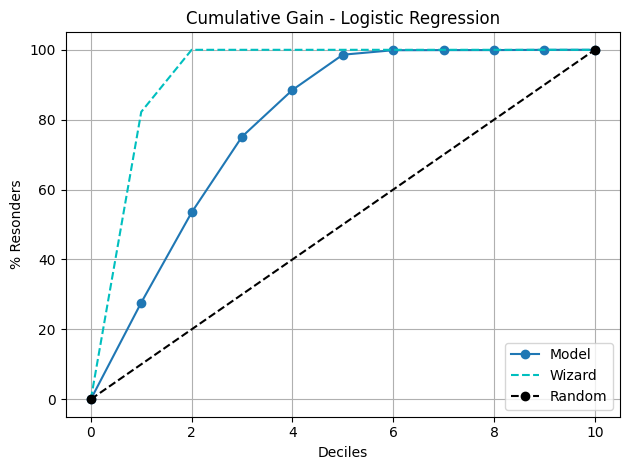

In [13]:
sp.kds.plot_cumulative_gain(y_val, y_hat_log[:,1], title='Cumulative Gain - Logistic Regression');

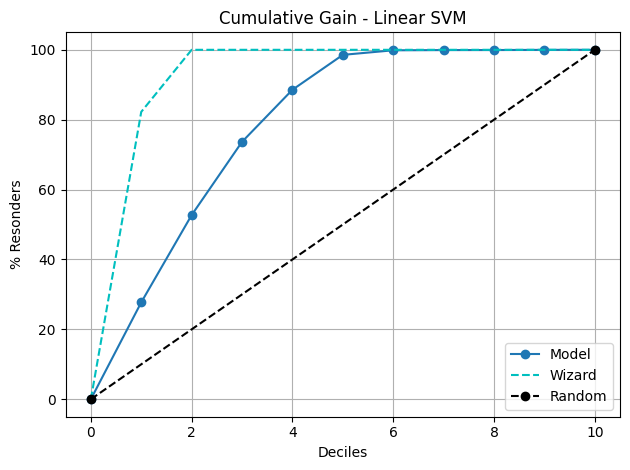

In [14]:
sp.kds.plot_cumulative_gain(y_val, y_hat_lin[:,1], title='Cumulative Gain - Linear SVM');

# 2.0 Non-linear Models

## 2.1. Single Tranning (default params)

In [15]:
# model initialization
knn = KNeighborsClassifier(n_neighbors=5)

# Train
knn.fit(X_train, y_train)

# Predict
knn_proba = knn.predict_proba(X_val)

## 2.2 Baseline Performance

In [16]:
# KNN
precision_knn = precision_at_k(y_true=y_val, y_proba=knn_proba, k=20000)
recall_knn = recall_at_k(y_true=y_val, y_proba=knn_proba, k=20000)

# Dataframe
results_knn = pd.DataFrame({'Model': ['KNN'],
                        '@k': 20000,
                        'Precision@k': precision_knn,
                        'Recall@k': recall_knn})
results_knn

,Model,@k,Precision@k,Recall@k
0,KNN,20000,0.28305,0.610745


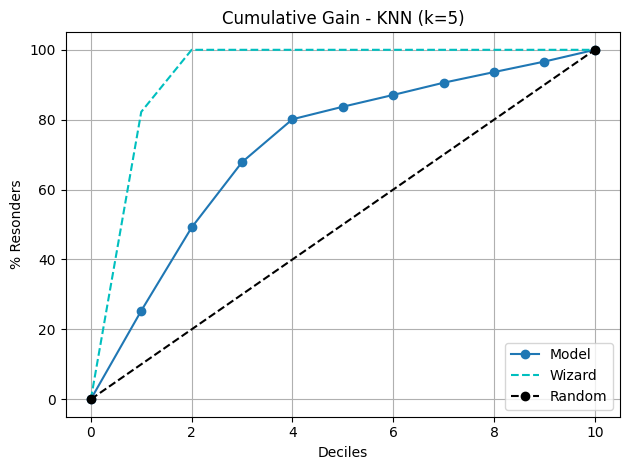

In [17]:
sp.kds.plot_cumulative_gain(y_val, knn_proba[:,1], title='Cumulative Gain - KNN (k=5)');

# 3.0 Cross validation

## 3.1 SGD Classifier: Linear SVM  

In [66]:
sgd_lin = SGDClassifier(loss='hinge')

# Converting prediction to probabilities
lim_svm = CalibratedClassifierCV(sgd_lin)

# CV fitting
linear_svm_results = cross_validate(lim_svm, X, y, cv=5, scoring={'recall': recall_at_k_scorer, 'precision': precision_at_k_scorer, 'f1': f1_at_k_scorer})

In [ ]:
# Performance results
linear_svm_df = pd.DataFrame(linear_svm_results)
linear_svm_df.rename(columns={'test_recall': 'recall@k', 'test_precision': 'precision@k', 'fit_time': 'fit_time', 'test_f1': 'f1-score@k'}, inplace=True)
linear_svm_df.drop(columns='score_time', inplace=True)
linear_svm_df = linear_svm_df[['recall', 'precision', 'f1-score', 'fit_time']]
linear_svm_df

## 3.2 SGD Classifier: Logistic regression 

In [ ]:
sgd_log = SGDClassifier(loss='log_loss')

# CV fitting
log_loss = cross_validate(sgd_log, X, y, cv=5, scoring={'recall': recall_at_k_scorer, 'precision': precision_at_k_scorer, 'f1': f1_at_k_scorer})

In [ ]:
# Performance results
log_loss_df = pd.DataFrame(log_loss)
log_loss_df.rename(columns={'test_recall': 'recall@k', 'test_precision': 'precision@k', 'fit_time': 'fit_time', 'test_f1': 'f1-score@k'}, inplace=True)
log_loss_df.drop(columns='score_time', inplace=True)
log_loss_df = linear_svm_df[['recall', 'precision', 'f1-score', 'fit_time']]
log_loss_df

## 3.3 K-Neighbors Classifier 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

# CV fitting
knn_results = cross_validate(knn, X, y, cv=5, scoring={'recall': recall_at_k_scorer, 'precision': precision_at_k_scorer, 'f1': f1_at_k_scorer})

In [ ]:
# Performance results
knn_df = pd.DataFrame(knn_results)
knn_df.rename(columns={'test_recall': 'recall@k', 'test_precision': 'precision@k', 'fit_time': 'fit_time', 'test_f1': 'f1-score@k'}, inplace=True)
knn_df.drop(columns='score_time', inplace=True)
knn_df = linear_svm_df[['recall', 'precision', 'f1-score', 'fit_time']]
knn_df